#### 1. Imports + config

In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import transforms

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 110


#### 2. Hex math helpers (axial coordinates)
This uses axial coordinates (q, r) with pointy-top hexes.

In [25]:
SQRT3 = math.sqrt(3)


def hex_corners_pointy(cx, cy, size):
    """
    Return 6 (x,y) points for a pointy-top hex centered at (cx, cy).
    """
    pts = []
    for i in range(6):
        angle = math.radians(60 * i - 30)  # -30 makes it pointy-top
        pts.append((cx + size * math.cos(angle), cy + size * math.sin(angle)))
    return pts


def axial_to_pixel_pointy(q, r, size):
    """
    Convert axial coords (q, r) to pixel center (x, y) for pointy-top hex layout.
    Red Blob Games convention.
    """
    x = size * SQRT3 * (q + r / 2)
    y = size * 1.5 * r
    return x, y


def rotate_point(x, y, cx, cy, angle_deg):
    """
    Rotate point (x, y) around center (cx, cy) by angle_deg degrees.
    """
    rad = math.radians(angle_deg)
    cos_a = math.cos(rad)
    sin_a = math.sin(rad)
    dx = x - cx
    dy = y - cy
    return cx + dx * cos_a - dy * sin_a, cy + dx * sin_a + dy * cos_a


def oriented_line_end(cx, cy, size, angle_deg, length=0.7):
    """
    Compute endpoint for an oriented line starting at (cx, cy).
    angle_deg is in degrees; length scaled by hex size.
    """
    rad = math.radians(angle_deg)
    x2 = cx + length * size * math.cos(rad)
    y2 = cy + length * size * math.sin(rad)
    return x2, y2

#### 3. Draw a hex grid

In [26]:
def draw_hex_grid(radius=5, size=1.0, tile_defs=None, tile_map=None, title=None, draw_edges=True):
    """
    Draw a hex grid in axial coords with 'radius' around (0,0).
    tile_defs: list of tile definitions (dicts), e.g.:
        [{"name": "Grass", "image": <HxWx(3|4) ndarray>}, ...]
        Images are rendered pixelated (nearest) and clipped to hex shape.
    tile_map: dict mapping (q, r) -> {"tile": <index>, "rot": <0..5>}
        rot is a multiple of 60 degrees (0..5).
    """
    if tile_defs is None:
        tile_defs = []
    if tile_map is None:
        tile_map = {}


    # We'll draw images first, then overlay grid edges via a PatchCollection
    edge_patches = []


    fig, ax = plt.subplots()


    # Precompute hex bounding box dims for pointy-top
    hex_w = SQRT3 * size  # width between left/right vertices
    hex_h = 2.0 * size    # height between top/bottom vertices


    # Hex "disk" of radius N in axial coords
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            cx, cy = axial_to_pixel_pointy(q, r, size)
            corners = hex_corners_pointy(cx, cy, size)


            # Always capture an edge polygon (no fill) for overlay
            edge_patches.append(Polygon(corners, closed=True, fill=False))


            info = tile_map.get((q, r))
            if info is not None and isinstance(info, dict):
                idx = info.get("tile", 0)
                rot = info.get("rot", 0)  # 0..5
                angle_deg = (rot % 6) * 60
                if 0 <= idx < len(tile_defs):
                    tdef = tile_defs[idx]
                    img = tdef.get("image")
                    if img is not None:
                        # Draw the bitmap inside the hex's bounding box and clip to the hex
                        extent = (cx - hex_w/2.0, cx + hex_w/2.0, cy - hex_h/2.0, cy + hex_h/2.0)
                        im = ax.imshow(img, extent=extent, origin="lower", interpolation="nearest")
                        # Rotate around hex center by multiples of 60°
                        im.set_transform(transforms.Affine2D().rotate_deg_around(cx, cy, angle_deg) + ax.transData)
                        # Clip to the exact hex polygon in data coords
                        clip_poly = Polygon(corners, closed=True)
                        clip_poly.set_transform(ax.transData)
                        im.set_clip_path(clip_poly)
                    else:
                        # Fallback: simple face fill if image missing
                        fill_poly = Polygon(corners, closed=True)
                        ax.add_patch(fill_poly)
                        fc = tdef.get("facecolor", "white")
                        fill_poly.set_facecolor(fc)
                        fill_poly.set_edgecolor("none")
                # else: out of range tile index -> leave empty
            # else: no tile mapping -> leave empty


    # Overlay grid edges on top
    if draw_edges and edge_patches:
        pc = PatchCollection(edge_patches, edgecolor="black", facecolor="none", linewidth=0.8)
        ax.add_collection(pc)


    ax.set_aspect("equal")
    ax.autoscale_view()
    ax.set_axis_off()


    if title:
        ax.set_title(title)


    return fig, ax

#### 4. Quick test render

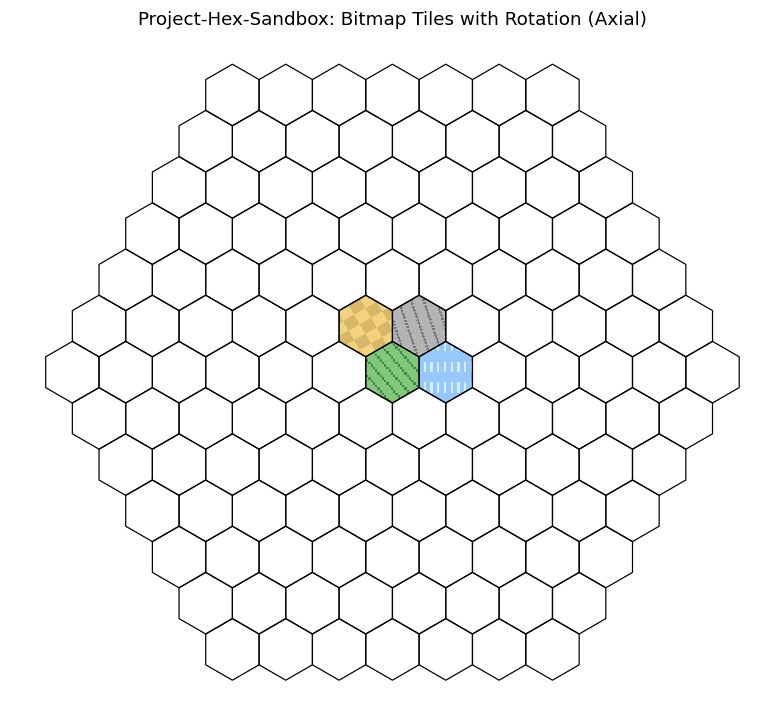

In [33]:
# Define low-res bitmap tiles (RGBA)
def make_tile_bitmap(name, w=24, h=24):
    img = np.zeros((h, w, 4), dtype=np.uint8)
    # Base color per tile
    if name == "Grass":
        base = np.array([130, 200, 120, 255], dtype=np.uint8)
        stripe = np.array([60, 140, 80, 255], dtype=np.uint8)
        for y in range(h):
            for x in range(w):
                img[y, x] = base
                if (x + y) % 6 == 0:
                    img[y, x] = stripe
    elif name == "Water":
        base = np.array([150, 200, 255, 255], dtype=np.uint8)
        foam = np.array([210, 240, 255, 255], dtype=np.uint8)
        for y in range(h):
            for x in range(w):
                img[y, x] = base
                if (y // 4) % 2 == 0 and (x % 3 == 0):
                    img[y, x] = foam
    elif name == "Mountain":
        base = np.array([180, 180, 180, 255], dtype=np.uint8)
        vein = np.array([120, 120, 120, 255], dtype=np.uint8)
        for y in range(h):
            for x in range(w):
                img[y, x] = base
                if ((x - y) % 7) == 0:
                    img[y, x] = vein
    elif name == "Desert":
        base = np.array([242, 210, 126, 255], dtype=np.uint8)
        dune = np.array([214, 184, 104, 255], dtype=np.uint8)
        for y in range(h):
            for x in range(w):
                img[y, x] = base
                if (x // 5 + y // 5) % 2 == 0:
                    img[y, x] = dune
    else:
        img[..., :] = np.array([220, 220, 220, 255], dtype=np.uint8)
    return img


tile_defs = [
    {"name": "Grass", "image": make_tile_bitmap("Grass")},
    {"name": "Water", "image": make_tile_bitmap("Water")},
    {"name": "Mountain", "image": make_tile_bitmap("Mountain")},
    {"name": "Desert", "image": make_tile_bitmap("Desert")},
]


tile_map = {
    (0, 0): {"tile": 0, "rot": 3},
    (1, 0): {"tile": 1, "rot": 3},  # 120°
    (0, 1): {"tile": 2, "rot": 4},  # 240°
    (-1, 1): {"tile": 3, "rot": 5}, # 300°
}

fig, ax = draw_hex_grid(
    radius=6,
    size=1.0,
    tile_defs=tile_defs,
    tile_map=tile_map,
    title="Project-Hex-Sandbox: Bitmap Tiles with Rotation (Axial)",
    draw_edges=True
)
plt.show()



In [34]:
def show_tiles_row(tile_defs, size=1.0, gap=None, title=None, draw_edges=True, show_labels=True):
    """
    Display all tiles in a single horizontal row at rotation 0.
    - tile_defs: list of dicts, each with optional keys:
        {"name": str, "image": ndarray (H×W×(3|4)), "facecolor": str}
    - size: hex size used for layout
    - gap: horizontal gap between hex centers (defaults to 0.25 * hex_w)
    - draw_edges: overlay hex outlines
    - show_labels: draw tile names under each hex
    """
    if tile_defs is None:
        tile_defs = []
    if gap is None:
        gap = 0.25 * SQRT3 * size
    

    fig, ax = plt.subplots()
    hex_w = SQRT3 * size
    hex_h = 2.0 * size
    

    for i, tdef in enumerate(tile_defs):
        cx = i * (hex_w + gap)
        cy = 0.0
        corners = hex_corners_pointy(cx, cy, size)
        extent = (cx - hex_w/2.0, cx + hex_w/2.0, cy - hex_h/2.0, cy + hex_h/2.0)
        img = tdef.get("image")
        if img is not None:
            im = ax.imshow(img, extent=extent, origin="lower", interpolation="nearest")
            clip_poly = Polygon(corners, closed=True)
            clip_poly.set_transform(ax.transData)
            im.set_clip_path(clip_poly)
        else:
            fill_poly = Polygon(corners, closed=True)
            ax.add_patch(fill_poly)
            fc = tdef.get("facecolor", "white")
            fill_poly.set_facecolor(fc)
            fill_poly.set_edgecolor("none")
        if draw_edges:
            edge = Polygon(corners, closed=True, fill=False)
            ax.add_patch(edge)
            edge.set_edgecolor("black")
            edge.set_linewidth(0.8)
        if show_labels:
            name = tdef.get("name", f"Tile {i}")
            ax.text(cx, cy - hex_h * 0.65, name, ha="center", va="top", fontsize=9)
    

    ax.set_aspect("equal")
    ax.autoscale_view()
    ax.set_axis_off()
    if title:
        ax.set_title(title)
    return fig, ax

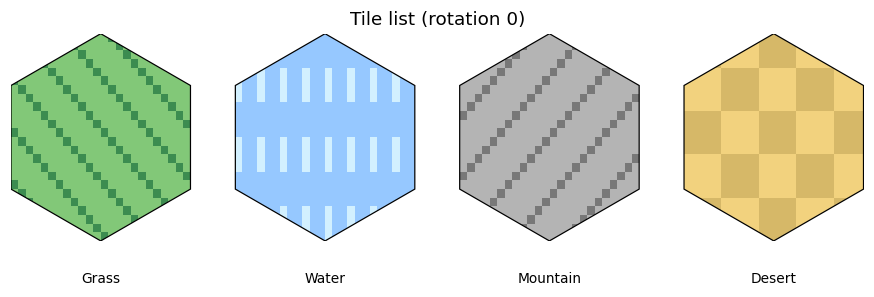

In [35]:
fig, ax = show_tiles_row(tile_defs, size=1.0, title="Tile list (rotation 0)")
plt.show()